# Bayes Tree Replay Memorization

In [19]:
import pandas as pd
import numpy as np
import sys
from sklearn.model_selection import train_test_split

import MySQLdb.cursors
import MySQLdb

import bayes_tree # contains bayes tree class
import config as cfg # contains unit lookups/helper functions/credentials

## Get Replay List and Prepare MySQL Cursors

In [7]:
database_list = ['sc_pvp','sc_pvt','tvt']  # 'sc_pvz' 'tvz','zvz'
connection_list = []
cursor_list = []
for database in database_list:
    db = MySQLdb.connect(
    host = cfg.credentials['host'],
    user = cfg.credentials['user'],
    passwd = cfg.credentials['passwd'],
    database = database,
    cursorclass = MySQLdb.cursors.SSCursor)
    connection_list.append(db)
    cursor_list.append(db.cursor())

In [8]:
!ls pickles

clustered_replays.pickle player_races.pickle      raw_train_builds.pickle
memo_tree.pickle         raw_id_list.pickle       test_replays.pickle
obs_id_list.pickle       raw_obs.pickle           unit_counts.pickle


In [9]:
clustered_replays = cfg.from_pickle('pickles/clustered_replays.pickle')
clustered_replays['playerreplayID'] = [item[1] for item in clustered_replays.index]
clustered_replays['cursor'] = [item[0] for item in clustered_replays.index]
clustered_replays.head()

,cluster,race,playerreplayID,cursor
"(sc_pvt, 5)",2,1,5,sc_pvt
"(sc_pvt, 8)",1,1,8,sc_pvt
"(sc_pvt, 10)",6,1,10,sc_pvt
"(sc_pvt, 11)",0,1,11,sc_pvt
"(sc_pvt, 14)",2,1,14,sc_pvt


In [10]:
train_replays, test_replays = train_test_split(clustered_replays, test_size=0.05, random_state=42)
cfg.to_pickle(test_replays,'test_replays')

## Generate Build Trees

In [11]:
def get_builds(playerreplayIDs,time,cursor):
    n = 300
    results = []
    request_chunks = [playerreplayIDs[i * n:(i + 1) * n] for i in range((len(playerreplayIDs) + n - 1) // n )]
    for segment in request_chunks:
        playerreplayIDs_string = ",".join(str(x) for x in segment)
        query = """
            SELECT playerreplay.PlayerReplayID, unit.UnitTypeID, CAST(ChangeTime / 24 AS UNSIGNED) AS time 
            FROM (attributechange LEFT JOIN unit ON unit.UnitID = attributechange.UnitID) 
            LEFT JOIN playerreplay ON playerreplay.PlayerReplayID = unit.PlayerReplayID
            WHERE AttributeTypeID = 28 AND unit.PlayerReplayID in ({}) AND ChangeVal = 1 AND ChangeTime <= {}
            ORDER BY ChangeTime,UnitTypeID;
        """.format(playerreplayIDs_string,time)
        print(query)
    
        cursor.execute(query)
        results += cursor.fetchall()
        
    print('done!')
    ids = set(map(lambda x:x[0], results))
    results_by_ids = [[y[1:3] for y in results if y[0]==x] for x in ids]
    
    return results_by_ids,ids


def process_builds(results):
    
    build_list = []
    
    for result in results:
    
        build_order = tuple([x[0] for x in result])
        
        for index,item in enumerate(build_order):
            if item in cfg.tree_converts.keys():
                build_order[index] = cfg.tree_converts[item]

        build_tup = []
        for last_elem in range(1,len(build_order)+1):
            seq = build_order[0:last_elem]
            if seq[-1] not in cfg.tree_choices.keys():
                continue
            build_tup.append((seq[-1],seq.count(seq[-1])))
        timing = tuple([x[1] for x in result])
        build_list.append({'build' : build_tup , 'time' : timing})
    return build_list

In [12]:
try:
    raw_builds = cfg.from_pickle('pickles/raw_train_builds.pickle')
    id_list = cfg.from_pickle('pickles/raw_id_list.pickle')
except:
    print('generating builds')
    raw_builds = []
    id_list = []
    for index,database in enumerate(database_list):
        playerreplayIDs = train_replays['playerreplayID'][train_replays['cursor'] == database]
        cursor = cursor_list[index]
        builds, ids = get_builds(playerreplayIDs,cfg.TIME,cursor)
        raw_builds.append(builds)
        id_list.append(ids)
    
    cfg.to_pickle(raw_builds,'raw_train_builds')
    cfg.to_pickle(id_list,'raw_id_list')

In [13]:
processed_builds = []
for builds in raw_builds:
    processed_builds.append(process_builds(builds))

In [14]:
all_builds = []
all_ids = []
all_unique_ids = []
all_races = []
for matchup_ind,matchup in enumerate(processed_builds):
    for match_ind,match in enumerate(matchup):
        
        live_id = list(id_list[matchup_ind])[match_ind]
        all_ids.append(live_id)
        unique_id = (database_list[matchup_ind],live_id)
        all_unique_ids.append(unique_id)
        
        race = clustered_replays['race'][clustered_replays.index == unique_id].values[0]
        all_races.append(race)
     
        match['cluster'] = clustered_replays['cluster'][clustered_replays.index == unique_id].values[0]
        match['freq'] = 1 / len(train_replays)
        match['name'] = [f'{x[1]}x {cfg.tree_choices[x[0]]}' for x in match['build']]
           
        all_builds.append(match)

In [32]:
from importlib import reload
reload(bayes_tree)

<module 'bayes_tree' from '/Users/alexanderparker/coding/starcraft/bayes_tree.py'>

In [33]:
tree = bayes_tree.tree()
counter = 0
for build in all_builds:
    counter += 1
    print(f'Adding build #{counter}')
    tree.add_build(build)
tree.fit_nodes(3,15) #3 obs cutoff, 15 second default std
tree.prepare()

Adding build #1
Adding build #2
Adding build #3
Adding build #4
Adding build #5
Adding build #6
Adding build #7
Adding build #8
Adding build #9
Adding build #10
Adding build #11
Adding build #12
Adding build #13
Adding build #14
Adding build #15
Adding build #16
Adding build #17
Adding build #18
Adding build #19
Adding build #20
Adding build #21
Adding build #22
Adding build #23
Adding build #24
Adding build #25
Adding build #26
Adding build #27
Adding build #28
Adding build #29
Adding build #30
Adding build #31
Adding build #32
Adding build #33
Adding build #34
Adding build #35
Adding build #36
Adding build #37
Adding build #38
Adding build #39
Adding build #40
Adding build #41
Adding build #42
Adding build #43
Adding build #44
Adding build #45
Adding build #46
Adding build #47
Adding build #48
Adding build #49
Adding build #50
Adding build #51
Adding build #52
Adding build #53
Adding build #54
Adding build #55
Adding build #56
Adding build #57
Adding build #58
Adding build #59
Adding

Adding build #571
Adding build #572
Adding build #573
Adding build #574
Adding build #575
Adding build #576
Adding build #577
Adding build #578
Adding build #579
Adding build #580
Adding build #581
Adding build #582
Adding build #583
Adding build #584
Adding build #585
Adding build #586
Adding build #587
Adding build #588
Adding build #589
Adding build #590
Adding build #591
Adding build #592
Adding build #593
Adding build #594
Adding build #595
Adding build #596
Adding build #597
Adding build #598
Adding build #599
Adding build #600
Adding build #601
Adding build #602
Adding build #603
Adding build #604
Adding build #605
Adding build #606
Adding build #607
Adding build #608
Adding build #609
Adding build #610
Adding build #611
Adding build #612
Adding build #613
Adding build #614
Adding build #615
Adding build #616
Adding build #617
Adding build #618
Adding build #619
Adding build #620
Adding build #621
Adding build #622
Adding build #623
Adding build #624
Adding build #625
Adding bui

Adding build #1037
Adding build #1038
Adding build #1039
Adding build #1040
Adding build #1041
Adding build #1042
Adding build #1043
Adding build #1044
Adding build #1045
Adding build #1046
Adding build #1047
Adding build #1048
Adding build #1049
Adding build #1050
Adding build #1051
Adding build #1052
Adding build #1053
Adding build #1054
Adding build #1055
Adding build #1056
Adding build #1057
Adding build #1058
Adding build #1059
Adding build #1060
Adding build #1061
Adding build #1062
Adding build #1063
Adding build #1064
Adding build #1065
Adding build #1066
Adding build #1067
Adding build #1068
Adding build #1069
Adding build #1070
Adding build #1071
Adding build #1072
Adding build #1073
Adding build #1074
Adding build #1075
Adding build #1076
Adding build #1077
Adding build #1078
Adding build #1079
Adding build #1080
Adding build #1081
Adding build #1082
Adding build #1083
Adding build #1084
Adding build #1085
Adding build #1086
Adding build #1087
Adding build #1088
Adding build

Adding build #1641
Adding build #1642
Adding build #1643
Adding build #1644
Adding build #1645
Adding build #1646
Adding build #1647
Adding build #1648
Adding build #1649
Adding build #1650
Adding build #1651
Adding build #1652
Adding build #1653
Adding build #1654
Adding build #1655
Adding build #1656
Adding build #1657
Adding build #1658
Adding build #1659
Adding build #1660
Adding build #1661
Adding build #1662
Adding build #1663
Adding build #1664
Adding build #1665
Adding build #1666
Adding build #1667
Adding build #1668
Adding build #1669
Adding build #1670
Adding build #1671
Adding build #1672
Adding build #1673
Adding build #1674
Adding build #1675
Adding build #1676
Adding build #1677
Adding build #1678
Adding build #1679
Adding build #1680
Adding build #1681
Adding build #1682
Adding build #1683
Adding build #1684
Adding build #1685
Adding build #1686
Adding build #1687
Adding build #1688
Adding build #1689
Adding build #1690
Adding build #1691
Adding build #1692
Adding build

Adding build #2730
Adding build #2731
Adding build #2732
Adding build #2733
Adding build #2734
Adding build #2735
Adding build #2736
Adding build #2737
Adding build #2738
Adding build #2739
Adding build #2740
Adding build #2741
Adding build #2742
Adding build #2743
Adding build #2744
Adding build #2745
Adding build #2746
Adding build #2747
Adding build #2748
Adding build #2749
Adding build #2750
Adding build #2751
Adding build #2752
Adding build #2753
Adding build #2754
Adding build #2755
Adding build #2756
Adding build #2757
Adding build #2758
Adding build #2759
Adding build #2760
Adding build #2761
Adding build #2762
Adding build #2763
Adding build #2764
Adding build #2765
Adding build #2766
Adding build #2767
Adding build #2768
Adding build #2769
Adding build #2770
Adding build #2771
Adding build #2772
Adding build #2773
Adding build #2774
Adding build #2775
Adding build #2776
Adding build #2777
Adding build #2778
Adding build #2779
Adding build #2780
Adding build #2781
Adding build

Adding build #3292
Adding build #3293
Adding build #3294
Adding build #3295
Adding build #3296
Adding build #3297
Adding build #3298
Adding build #3299
Adding build #3300
Adding build #3301
Adding build #3302
Adding build #3303
Adding build #3304
Adding build #3305
Adding build #3306
Adding build #3307
Adding build #3308
Adding build #3309
Adding build #3310
Adding build #3311
Adding build #3312
Adding build #3313
Adding build #3314
Adding build #3315
Adding build #3316
Adding build #3317
Adding build #3318
Adding build #3319
Adding build #3320
Adding build #3321
Adding build #3322
Adding build #3323
Adding build #3324
Adding build #3325
Adding build #3326
Adding build #3327
Adding build #3328
Adding build #3329
Adding build #3330
Adding build #3331
Adding build #3332
Adding build #3333
Adding build #3334
Adding build #3335
Adding build #3336
Adding build #3337
Adding build #3338
Adding build #3339
Adding build #3340
Adding build #3341
Adding build #3342
Adding build #3343
Adding build

Adding build #3790
Adding build #3791
Adding build #3792
Adding build #3793
Adding build #3794
Adding build #3795
Adding build #3796
Adding build #3797
Adding build #3798
Adding build #3799
Adding build #3800
Adding build #3801
Adding build #3802
Adding build #3803
Adding build #3804
Adding build #3805
Adding build #3806
Adding build #3807
Adding build #3808
Adding build #3809
Adding build #3810
Adding build #3811
Adding build #3812
Adding build #3813
Adding build #3814
Adding build #3815
Adding build #3816
Adding build #3817
Adding build #3818
Adding build #3819
Adding build #3820
Adding build #3821
Adding build #3822
Adding build #3823
Adding build #3824
Adding build #3825
Adding build #3826
Adding build #3827
Adding build #3828
Adding build #3829
Adding build #3830
Adding build #3831
Adding build #3832
Adding build #3833
Adding build #3834
Adding build #3835
Adding build #3836
Adding build #3837
Adding build #3838
Adding build #3839
Adding build #3840
Adding build #3841
Adding build

Adding build #4448
Adding build #4449
Adding build #4450
Adding build #4451
Adding build #4452
Adding build #4453
Adding build #4454
Adding build #4455
Adding build #4456
Adding build #4457
Adding build #4458
Adding build #4459
Adding build #4460
Adding build #4461
Adding build #4462
Adding build #4463
Adding build #4464
Adding build #4465
Adding build #4466
Adding build #4467
Adding build #4468
Adding build #4469
Adding build #4470
Adding build #4471
Adding build #4472
Adding build #4473
Adding build #4474
Adding build #4475
Adding build #4476
Adding build #4477
Adding build #4478
Adding build #4479
Adding build #4480
Adding build #4481
Adding build #4482
Adding build #4483
Adding build #4484
Adding build #4485
Adding build #4486
Adding build #4487
Adding build #4488
Adding build #4489
Adding build #4490
Adding build #4491
Adding build #4492
Adding build #4493
Adding build #4494
Adding build #4495
Adding build #4496
Adding build #4497
Adding build #4498
Adding build #4499
Adding build

In [37]:
test = tree.predict(60*10,read_root=True)
sum([x[1] for x in test])

0.05277722870132423

In [12]:
sys.setrecursionlimit(100000)
cfg.to_pickle(tree,'memo_tree')
sys.setrecursionlimit(1000)

In [19]:
from anytree import Node, RenderTree, AsciiStyle, PreOrderIter
len([0 for _ in PreOrderIter(tree.read_root)])

539230

In [21]:
hist_tree = bayes_tree()
counter = 0
for build in all_builds:
    counter += 1
    print(f'Adding build #{counter}')
    hist_tree.add_build(build)

Adding build #1
Adding build #2
Adding build #3
Adding build #4
Adding build #5
Adding build #6
Adding build #7
Adding build #8
Adding build #9
Adding build #10
Adding build #11
Adding build #12
Adding build #13
Adding build #14
Adding build #15
Adding build #16
Adding build #17
Adding build #18
Adding build #19
Adding build #20
Adding build #21
Adding build #22
Adding build #23
Adding build #24
Adding build #25
Adding build #26
Adding build #27
Adding build #28
Adding build #29
Adding build #30
Adding build #31
Adding build #32
Adding build #33
Adding build #34
Adding build #35
Adding build #36
Adding build #37
Adding build #38
Adding build #39
Adding build #40
Adding build #41
Adding build #42
Adding build #43
Adding build #44
Adding build #45
Adding build #46
Adding build #47
Adding build #48
Adding build #49
Adding build #50
Adding build #51
Adding build #52
Adding build #53
Adding build #54
Adding build #55
Adding build #56
Adding build #57
Adding build #58
Adding build #59
Adding

Adding build #663
Adding build #664
Adding build #665
Adding build #666
Adding build #667
Adding build #668
Adding build #669
Adding build #670
Adding build #671
Adding build #672
Adding build #673
Adding build #674
Adding build #675
Adding build #676
Adding build #677
Adding build #678
Adding build #679
Adding build #680
Adding build #681
Adding build #682
Adding build #683
Adding build #684
Adding build #685
Adding build #686
Adding build #687
Adding build #688
Adding build #689
Adding build #690
Adding build #691
Adding build #692
Adding build #693
Adding build #694
Adding build #695
Adding build #696
Adding build #697
Adding build #698
Adding build #699
Adding build #700
Adding build #701
Adding build #702
Adding build #703
Adding build #704
Adding build #705
Adding build #706
Adding build #707
Adding build #708
Adding build #709
Adding build #710
Adding build #711
Adding build #712
Adding build #713
Adding build #714
Adding build #715
Adding build #716
Adding build #717
Adding bui

Adding build #1141
Adding build #1142
Adding build #1143
Adding build #1144
Adding build #1145
Adding build #1146
Adding build #1147
Adding build #1148
Adding build #1149
Adding build #1150
Adding build #1151
Adding build #1152
Adding build #1153
Adding build #1154
Adding build #1155
Adding build #1156
Adding build #1157
Adding build #1158
Adding build #1159
Adding build #1160
Adding build #1161
Adding build #1162
Adding build #1163
Adding build #1164
Adding build #1165
Adding build #1166
Adding build #1167
Adding build #1168
Adding build #1169
Adding build #1170
Adding build #1171
Adding build #1172
Adding build #1173
Adding build #1174
Adding build #1175
Adding build #1176
Adding build #1177
Adding build #1178
Adding build #1179
Adding build #1180
Adding build #1181
Adding build #1182
Adding build #1183
Adding build #1184
Adding build #1185
Adding build #1186
Adding build #1187
Adding build #1188
Adding build #1189
Adding build #1190
Adding build #1191
Adding build #1192
Adding build

Adding build #2067
Adding build #2068
Adding build #2069
Adding build #2070
Adding build #2071
Adding build #2072
Adding build #2073
Adding build #2074
Adding build #2075
Adding build #2076
Adding build #2077
Adding build #2078
Adding build #2079
Adding build #2080
Adding build #2081
Adding build #2082
Adding build #2083
Adding build #2084
Adding build #2085
Adding build #2086
Adding build #2087
Adding build #2088
Adding build #2089
Adding build #2090
Adding build #2091
Adding build #2092
Adding build #2093
Adding build #2094
Adding build #2095
Adding build #2096
Adding build #2097
Adding build #2098
Adding build #2099
Adding build #2100
Adding build #2101
Adding build #2102
Adding build #2103
Adding build #2104
Adding build #2105
Adding build #2106
Adding build #2107
Adding build #2108
Adding build #2109
Adding build #2110
Adding build #2111
Adding build #2112
Adding build #2113
Adding build #2114
Adding build #2115
Adding build #2116
Adding build #2117
Adding build #2118
Adding build

Adding build #2831
Adding build #2832
Adding build #2833
Adding build #2834
Adding build #2835
Adding build #2836
Adding build #2837
Adding build #2838
Adding build #2839
Adding build #2840
Adding build #2841
Adding build #2842
Adding build #2843
Adding build #2844
Adding build #2845
Adding build #2846
Adding build #2847
Adding build #2848
Adding build #2849
Adding build #2850
Adding build #2851
Adding build #2852
Adding build #2853
Adding build #2854
Adding build #2855
Adding build #2856
Adding build #2857
Adding build #2858
Adding build #2859
Adding build #2860
Adding build #2861
Adding build #2862
Adding build #2863
Adding build #2864
Adding build #2865
Adding build #2866
Adding build #2867
Adding build #2868
Adding build #2869
Adding build #2870
Adding build #2871
Adding build #2872
Adding build #2873
Adding build #2874
Adding build #2875
Adding build #2876
Adding build #2877
Adding build #2878
Adding build #2879
Adding build #2880
Adding build #2881
Adding build #2882
Adding build

Adding build #3397
Adding build #3398
Adding build #3399
Adding build #3400
Adding build #3401
Adding build #3402
Adding build #3403
Adding build #3404
Adding build #3405
Adding build #3406
Adding build #3407
Adding build #3408
Adding build #3409
Adding build #3410
Adding build #3411
Adding build #3412
Adding build #3413
Adding build #3414
Adding build #3415
Adding build #3416
Adding build #3417
Adding build #3418
Adding build #3419
Adding build #3420
Adding build #3421
Adding build #3422
Adding build #3423
Adding build #3424
Adding build #3425
Adding build #3426
Adding build #3427
Adding build #3428
Adding build #3429
Adding build #3430
Adding build #3431
Adding build #3432
Adding build #3433
Adding build #3434
Adding build #3435
Adding build #3436
Adding build #3437
Adding build #3438
Adding build #3439
Adding build #3440
Adding build #3441
Adding build #3442
Adding build #3443
Adding build #3444
Adding build #3445
Adding build #3446
Adding build #3447
Adding build #3448
Adding build

Adding build #3918
Adding build #3919
Adding build #3920
Adding build #3921
Adding build #3922
Adding build #3923
Adding build #3924
Adding build #3925
Adding build #3926
Adding build #3927
Adding build #3928
Adding build #3929
Adding build #3930
Adding build #3931
Adding build #3932
Adding build #3933
Adding build #3934
Adding build #3935
Adding build #3936
Adding build #3937
Adding build #3938
Adding build #3939
Adding build #3940
Adding build #3941
Adding build #3942
Adding build #3943
Adding build #3944
Adding build #3945
Adding build #3946
Adding build #3947
Adding build #3948
Adding build #3949
Adding build #3950
Adding build #3951
Adding build #3952
Adding build #3953
Adding build #3954
Adding build #3955
Adding build #3956
Adding build #3957
Adding build #3958
Adding build #3959
Adding build #3960
Adding build #3961
Adding build #3962
Adding build #3963
Adding build #3964
Adding build #3965
Adding build #3966
Adding build #3967
Adding build #3968
Adding build #3969
Adding build

Adding build #4388
Adding build #4389
Adding build #4390
Adding build #4391
Adding build #4392
Adding build #4393
Adding build #4394
Adding build #4395
Adding build #4396
Adding build #4397
Adding build #4398
Adding build #4399
Adding build #4400
Adding build #4401
Adding build #4402
Adding build #4403
Adding build #4404
Adding build #4405
Adding build #4406
Adding build #4407
Adding build #4408
Adding build #4409
Adding build #4410
Adding build #4411
Adding build #4412
Adding build #4413
Adding build #4414
Adding build #4415
Adding build #4416
Adding build #4417
Adding build #4418
Adding build #4419
Adding build #4420
Adding build #4421
Adding build #4422
Adding build #4423
Adding build #4424
Adding build #4425
Adding build #4426
Adding build #4427
Adding build #4428
Adding build #4429
Adding build #4430
Adding build #4431
Adding build #4432
Adding build #4433
Adding build #4434
Adding build #4435
Adding build #4436
Adding build #4437
Adding build #4438
Adding build #4439
Adding build

Adding build #4945
Adding build #4946
Adding build #4947
Adding build #4948
Adding build #4949
Adding build #4950
Adding build #4951
Adding build #4952
Adding build #4953
Adding build #4954
Adding build #4955
Adding build #4956
Adding build #4957
Adding build #4958
Adding build #4959
Adding build #4960
Adding build #4961
Adding build #4962
Adding build #4963
Adding build #4964
Adding build #4965
Adding build #4966
Adding build #4967
Adding build #4968
Adding build #4969
Adding build #4970
Adding build #4971
Adding build #4972
Adding build #4973
Adding build #4974
Adding build #4975
Adding build #4976
Adding build #4977
Adding build #4978
Adding build #4979
Adding build #4980
Adding build #4981
Adding build #4982
Adding build #4983
Adding build #4984
Adding build #4985
Adding build #4986
Adding build #4987
Adding build #4988
Adding build #4989
Adding build #4990
Adding build #4991
Adding build #4992
Adding build #4993
Adding build #4994
Adding build #4995
Adding build #4996
Adding build

Adding build #5506
Adding build #5507
Adding build #5508
Adding build #5509
Adding build #5510
Adding build #5511
Adding build #5512
Adding build #5513
Adding build #5514
Adding build #5515
Adding build #5516
Adding build #5517
Adding build #5518
Adding build #5519
Adding build #5520
Adding build #5521
Adding build #5522
Adding build #5523
Adding build #5524
Adding build #5525
Adding build #5526
Adding build #5527
Adding build #5528
Adding build #5529
Adding build #5530
Adding build #5531
Adding build #5532
Adding build #5533
Adding build #5534
Adding build #5535
Adding build #5536
Adding build #5537
Adding build #5538
Adding build #5539
Adding build #5540
Adding build #5541
Adding build #5542
Adding build #5543
Adding build #5544
Adding build #5545
Adding build #5546
Adding build #5547
Adding build #5548
Adding build #5549
Adding build #5550
Adding build #5551
Adding build #5552
Adding build #5553
Adding build #5554
Adding build #5555
Adding build #5556
Adding build #5557
Adding build

Adding build #5938
Adding build #5939
Adding build #5940
Adding build #5941
Adding build #5942
Adding build #5943
Adding build #5944
Adding build #5945
Adding build #5946
Adding build #5947
Adding build #5948
Adding build #5949
Adding build #5950
Adding build #5951
Adding build #5952
Adding build #5953
Adding build #5954
Adding build #5955
Adding build #5956
Adding build #5957
Adding build #5958
Adding build #5959
Adding build #5960
Adding build #5961
Adding build #5962
Adding build #5963
Adding build #5964
Adding build #5965
Adding build #5966
Adding build #5967
Adding build #5968
Adding build #5969
Adding build #5970
Adding build #5971
Adding build #5972
Adding build #5973
Adding build #5974
Adding build #5975
Adding build #5976
Adding build #5977
Adding build #5978
Adding build #5979
Adding build #5980
Adding build #5981
Adding build #5982
Adding build #5983
Adding build #5984
Adding build #5985
Adding build #5986
Adding build #5987
Adding build #5988
Adding build #5989
Adding build

Adding build #6387
Adding build #6388
Adding build #6389
Adding build #6390
Adding build #6391
Adding build #6392
Adding build #6393
Adding build #6394
Adding build #6395
Adding build #6396
Adding build #6397
Adding build #6398
Adding build #6399
Adding build #6400
Adding build #6401
Adding build #6402
Adding build #6403
Adding build #6404
Adding build #6405
Adding build #6406
Adding build #6407
Adding build #6408
Adding build #6409
Adding build #6410
Adding build #6411
Adding build #6412
Adding build #6413
Adding build #6414
Adding build #6415
Adding build #6416
Adding build #6417
Adding build #6418
Adding build #6419
Adding build #6420
Adding build #6421
Adding build #6422
Adding build #6423
Adding build #6424
Adding build #6425
Adding build #6426
Adding build #6427
Adding build #6428
Adding build #6429
Adding build #6430
Adding build #6431
Adding build #6432
Adding build #6433
Adding build #6434
Adding build #6435
Adding build #6436
Adding build #6437
Adding build #6438
Adding build

Adding build #6874
Adding build #6875
Adding build #6876
Adding build #6877
Adding build #6878
Adding build #6879
Adding build #6880
Adding build #6881
Adding build #6882
Adding build #6883
Adding build #6884
Adding build #6885
Adding build #6886
Adding build #6887
Adding build #6888
Adding build #6889
Adding build #6890
Adding build #6891
Adding build #6892
Adding build #6893
Adding build #6894
Adding build #6895
Adding build #6896
Adding build #6897
Adding build #6898
Adding build #6899
Adding build #6900
Adding build #6901
Adding build #6902
Adding build #6903
Adding build #6904
Adding build #6905
Adding build #6906
Adding build #6907
Adding build #6908
Adding build #6909
Adding build #6910
Adding build #6911
Adding build #6912
Adding build #6913
Adding build #6914
Adding build #6915
Adding build #6916
Adding build #6917
Adding build #6918
Adding build #6919
Adding build #6920
Adding build #6921
Adding build #6922
Adding build #6923
Adding build #6924
Adding build #6925
Adding build

Adding build #7316
Adding build #7317
Adding build #7318
Adding build #7319
Adding build #7320
Adding build #7321
Adding build #7322
Adding build #7323
Adding build #7324
Adding build #7325
Adding build #7326
Adding build #7327
Adding build #7328
Adding build #7329
Adding build #7330
Adding build #7331
Adding build #7332
Adding build #7333
Adding build #7334
Adding build #7335
Adding build #7336
Adding build #7337
Adding build #7338
Adding build #7339
Adding build #7340
Adding build #7341
Adding build #7342
Adding build #7343
Adding build #7344
Adding build #7345
Adding build #7346
Adding build #7347
Adding build #7348
Adding build #7349
Adding build #7350
Adding build #7351
Adding build #7352
Adding build #7353
Adding build #7354
Adding build #7355
Adding build #7356
Adding build #7357
Adding build #7358
Adding build #7359
Adding build #7360
Adding build #7361
Adding build #7362
Adding build #7363
Adding build #7364
Adding build #7365
Adding build #7366
Adding build #7367
Adding build

Adding build #7867
Adding build #7868
Adding build #7869
Adding build #7870
Adding build #7871
Adding build #7872
Adding build #7873
Adding build #7874
Adding build #7875
Adding build #7876
Adding build #7877
Adding build #7878
Adding build #7879
Adding build #7880
Adding build #7881
Adding build #7882
Adding build #7883
Adding build #7884
Adding build #7885
Adding build #7886
Adding build #7887
Adding build #7888
Adding build #7889
Adding build #7890
Adding build #7891
Adding build #7892
Adding build #7893
Adding build #7894
Adding build #7895
Adding build #7896
Adding build #7897
Adding build #7898
Adding build #7899
Adding build #7900
Adding build #7901
Adding build #7902
Adding build #7903
Adding build #7904
Adding build #7905
Adding build #7906
Adding build #7907
Adding build #7908
Adding build #7909
Adding build #7910
Adding build #7911
Adding build #7912
Adding build #7913
Adding build #7914
Adding build #7915
Adding build #7916
Adding build #7917
Adding build #7918
Adding build

In [29]:
hist = hist_tree.read_root.children[1].children[0].children[0].children[0].children[0].children[0].children[0].children[0].children[0].children[0].children[0].children[0].children[0]


In [31]:
import seaborn as sns

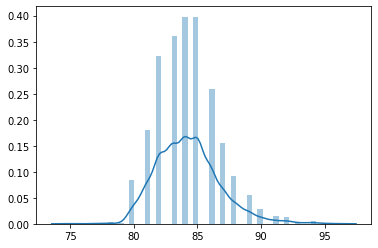

In [33]:
sns.distplot(hist.obs)

In [37]:
mean = np.mean(hist.obs)

In [38]:
std = np.std(hist.obs)

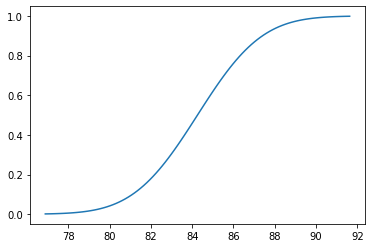

In [39]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math

mu = mean
sigma = std
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, stats.norm.cdf(x, mu, sigma))
plt.show()

In [40]:
tree.export_json('memorized_tree.json',read_tree=True)